In [1]:
import sys
sys.version 

'3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [4]:
import os
from langchain_community.chat_models.openai import ChatOpenAI

gpt3 = ChatOpenAI(model_name="gpt-3.5-turbo")
gpt4 = ChatOpenAI(model_name="gpt-4o")
gpt4_0 = ChatOpenAI(model_name="gpt-4o", temperature=0)

# Main State

In [5]:
import operator
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# main workflow state 정의
class AgentState(TypedDict):
    user_input: str
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# Supervisor

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder 
from pydantic import BaseModel 
from typing import Literal 

# 에이전트 목록 정의
members = ["problem_content_agent", "coding_agent", "code_analysis_agent", "Algorithm_agent"]

# routeResponse 모델 정의 (다음 에이전트를 결정)
class routeResponse(BaseModel): 
    # next: Literal[*options]  # This is the correct way to use Literal with options
    next: Literal["FINISH", "problem_content_agent", "coding_agent", "code_analysis_agent", "Algorithm_agent"]

# supervisor에이전트 함수: 대화를 관리하고 적절한 에이전트를 선택
def supervisor_agent(state):
    # 시스템 프롬프트: 각 에이전트의 역할과 작업 완료 후 FINISH 반환 규칙 설명
    supervisor_system_prompt = """
    You are the supervisor managing the conversation between agents. Each agent performs its task and reports back with their results and status. When the task is completed, respond with FINISH.
    
    Analyze the user's question and select the most appropriate agent to handle the task. 
    
    There are four types of tasks:
    1. Problem description: When the problem description is explained fully, respond with FINISH.
    2. Code implementation request: When the code has been successfully generated, respond with FINISH.
    3. Code review request: When the code analysis or review has been provided, respond with FINISH.
    4. Data structures or algorithm concept question: When the concept explanation is complete, respond with FINISH.
    
    Select the most appropriate agent based on the user's question:
    
    Available agents:
    1. problem_content_agent: Handles questions related to coding test problems and helps users understand the problem thoroughly. This agent can search websites to find accurate details about the coding test problem if necessary.
    2. coding_agent: Handles requests when the user provides a coding test problem and asks for code implementation.
    3. code_analysis_agent: Analyzes and reviews the user's code upon request.
    4. Algorithm_agent: Assists users when they ask about algorithms or data structures. This agent can use Wikipedia to search for accurate information about algorithms and data structures.
    5. FINISH: If the task is completed, respond with FINISH.
    
    Please determine the next step based on the conversation and choose one of the agents or FINISH.
    """

    options = ["FINISH"] + members # 선택 가능한 에이전트 목록

    # 프롬프트 템플릿 생성
    prompt = ChatPromptTemplate.from_messages( 
    [ 
        ("system", supervisor_system_prompt), 
        MessagesPlaceholder(variable_name="messages"), 
        ( 
            "human", 
            "Given the conversation above, who should act next?" 
            " Or should we FINISH? Select one of: {options}", 
        ), 
    ] 
    ).partial(options=str(options)) 

    # GPT-4 모델로 프롬프트 실행
    # llm = ChatOpenAI(model="gpt-4o", temperature=0.3)
    supervisor_chain = prompt | gpt4.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state) # 상태를 기반으로 적절한 에이전트 선택

# Problem Content Agent

In [7]:
import pandas as pd
from langchain.agents import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_core.messages import HumanMessage

# 데이터 프레임 불러오기 - Leetcode 1~20번 문제를 담고 있는 CSV 파일
df = pd.read_csv("dataset/Leetcode20.csv")

# TavilySearchResults 인스턴스를 생성 (Tavily API 사용, 검색 결과 최대 3개 반환)
search = TavilySearchResults(api_key=os.environ['TAVILY_API_KEY'], max_results=3)

# Tavily Search tool을 정의 - Leetcode 21번 이상 또는 타 코딩 사이트 문제를 검색하는 도구
tavily_search = Tool(
    name="tavily_search",
    func=lambda q: search.run(q),
    description="Use this tool to search for Leetcode problems numbered above 20 or problems from other coding test sites."
)

# 사용자 요청에 따라 문제를 설명하는 커스텀 프리픽스 정의
custom_prefix = """
Provide detailed and easy-to-understand explanations of coding test problems.

Constraints:
- If the problem is a Leetcode problem between 1 and 20, search for it in the CSV file named 'df'. Ensure the correct problem number is referenced based on user input, avoiding any confusion.
- For Leetcode problems above 20 or problems from other coding platforms, use Tavily to perform the search. When using Tavily, do not return just a link; instead, read and summarize the content in a detailed and user-friendly manner.

Expected Output:
- A clear description of the problem's objective.
- Explanation of the input and output formats.
- Key constraints and edge cases to consider.
- Possible strategies or algorithms to solve the problem (without providing full code).
- If searching via Tavily, include a thorough explanation that covers the problem's details based on the source material, avoiding any reliance on external links alone.
"""

# 데이터프레임과 Tavily Search 도구를 결합한 문제 설명용 에이전트 생성
problem_content_agent = create_pandas_dataframe_agent(
    llm=gpt4_0,
    df=df,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    allow_dangerous_code=True,
    verbose=True,
    extra_tools=[tavily_search],
    prefix = custom_prefix
)

In [8]:
# problem_content_agent 노드 생성 함수
def problem_content_agent_node(state: AgentState):
    result = problem_content_agent.invoke({"input": state["user_input"]})
    state["messages"].append(HumanMessage(content=result['output'], name="problem_content_agent"))
    return state

# Coding Agent

In [9]:
from crewai import Agent, Task, Crew
from crewai_tools import CodeInterpreterTool

# Python 코딩 테스트 문제를 해결하는 에이전트 생성
coding_agent = Agent(
    role="Python Coding Test Expert",
    goal="Solve coding test problems efficiently and produce clean, optimized Python code.",
    backstory="""
You are a Python coding test specialist with expertise in solving a wide variety of algorithmic problems.
Your experience includes competitive programming, coding challenges, and optimizing solutions for both time and space efficiency. 
You excel in breaking down complex problems into manageable steps and crafting Python code that adheres to best practices while passing all edge cases.
""",
    allow_code_execution=True, # 코드 실행을 허용
    llm=gpt4,
    verbose=True,
    tools=[CodeInterpreterTool()] # 에이전트가 사용할 도구 목록: CodeInterpreterTool()을 사용하여 코드를 분석하고 실행
)

# 코딩 문제 해결을 위한 작업 생성
coding_task = Task(
    description="""
Your task is to solve coding test problems using Python.
You must:
- Carefully consider any constraints provided in the problem (e.g., time/space limits).
- If the user specifies a particular data structure or algorithm to be used, follow their instructions.
- Write efficient, clean Python code that solves the problem while adhering to these constraints.
- Ensure the solution handles all test cases, including edge cases.
- Make sure you fully understand the problem requirements and avoid any confusion about the problem's content or constraints. If anything is unclear, review the problem and clarify before proceeding with the solution.
""",
    expected_output="""
The output should include:
- A clear explanation of the approach taken to solve the problem.
- Python code that adheres to any provided constraints and follows the user's instructions regarding specific data structures or algorithms.
- Explanation of the input and output formats.
- Consideration of time and space complexity.
- A final solution that is optimized and handles all edge cases.
""",
    agent=coding_agent
)

# Crew 생성 및 작업 추가
coding_crew = Crew(
    agents=[coding_agent],
    tasks=[coding_task],
    verbose=True
)

C:\Users\user\miniconda3\envs\test1\lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


In [10]:
# coding_agent 노드 생성 함수
def coding_agent_node(state):
    result = coding_crew.kickoff(inputs={"user_input": state["user_input"]})
    state["messages"].append(HumanMessage(content=result.raw, name="coding_agent"))
    return state

# Code Analysis Agent

In [11]:
import re
import io
import ast
import pstats
import timeit
import cProfile
import tempfile
import subprocess
import tracemalloc
from pydantic import Field
from typing import Optional, List
from typing import Type, Callable, Dict, Any
from langchain.schema import StrOutputParser

# 텍스트에서 파이썬 코드 블록을 추출하는 함수
def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0].strip()

# 모델과 구조화된 출력 체인을 생성하는 함수
def create_structured_output_chain(
    system_template: str, 
    human_template: str,
    model: str,
    struct: Type[BaseModel],
    partial_variables: Dict[str, Any] = {}
) -> Callable:

    # 시스템 및 사용자 입력을 위한 프롬프트 템플릿 생성
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", human_template)
    ]).partial(**partial_variables)

    # 모델 선택 딕셔너리
    model_mapping = {
        "gpt4_0": ChatOpenAI(model="gpt-4o", temperature=0),
        "gpt3_0": ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
        "gpt4": ChatOpenAI(model="gpt-4o"),
        "default": ChatOpenAI(model="gpt-3.5-turbo")
    }

    # 선택된 모델을 사용하여 체인 반환
    model_instance = model_mapping.get(model, model_mapping["default"])
        
    # 모델과 구조화된 출력 연결
    return prompt | model_instance.with_structured_output(struct)

# 코드 분석 상태를 나타내는 데이터 구조
class CodeAnalysisState(TypedDict):
    user_input: str
    output: str
    problem_description: str
    user_code: str
    input_data: str
    time_complexity: str
    space_complexity: str
    exec_code: str
    memory_code: str
    profiling_result: str
    memory_profile_output: str
    error_status: str
    exec_time: float
    memory_usage: dict
    code_complexity: dict

# 코드 분석 출력을 위한 데이터 정의
class CodeAnalysisOutput(BaseModel):
    problem_description: str = Field(description="The extracted problem description")
    user_code: str = Field(description="The extracted user's Python code")
    input_data: Optional[str] = Field(description="The extracted input data for testing the code")
    time_complexity: str = Field(description="Time complexity analysis of the user's code")
    space_complexity: str = Field(description="Space complexity analysis of the user's code")

# 사용자 입력을 파싱하는 함수
def parse_user_input(state: CodeAnalysisState):
    system_template = """
    Analyze the following user input and extract the following components:
    1. The coding test problem description
    2. The user's Python code
    3. The input data for testing the code (if provided)
    
    Then, based on the extracted user's Python code:
    4. Analyze and estimate the time complexity of the code
    5. Analyze and estimate the space complexity of the code
    
    Provide detailed explanations for your complexity analyses, considering the algorithmic approach used in the code.
    
    Provide your analysis in a structured format.
    """

    chain = create_structured_output_chain(
        system_template=system_template,
        human_template="{user_input}",
        model="gpt3_0",
        struct=CodeAnalysisOutput,
        partial_variables={"user_input": state["user_input"]}
    )
    
    return chain.invoke(state)

# 코드 복잡도 분석 함수
def analyze_code_complexity(state: CodeAnalysisState) -> CodeAnalysisState:
    code = state['user_code']
    
    # 코드의 AST를 분석하여 함수, 클래스, 루프, 조건문의 개수를 계산
    tree = ast.parse(code)
    code_complexity = {
        'num_functions': len([node for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]),
        'num_classes': len([node for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]),
        'num_loops': len([node for node in ast.walk(tree) if isinstance(node, (ast.For, ast.While))]),
        'num_conditionals': len([node for node in ast.walk(tree) if isinstance(node, ast.If)])
    }
    
    state['code_complexity'] = code_complexity
    return state

# 코드 실행을 위한 Python 코드 수정 함수
class ExecCodeOutput(BaseModel):
    exec_code: str = Field(description="The modified Python code that can be executed directly using Python's exec() function. This code includes hardcoded input data and any necessary function calls to ensure it runs without modification.")

def modify_user_code_for_execution(state: CodeAnalysisState): 
    # 입력 데이터 하드코딩 및 함수 호출 추가 템플릿
    system_template = """
    You are provided with a Python code and input data. Your task is to prepare the code so that it can be executed directly using the exec function in Python.
    
    Your task is to:
    1. Ensure that the input data is correctly hardcoded into the user's code in the appropriate places.
    2. If the code contains any functions (e.g., a main function or any other defined functions), add the necessary function calls at the bottom if they are missing.
    3. Do not change the structure or logic of the user's code.
    4. Ensure that after modification, the code is ready to be executed directly with the exec function.
    
    Please return the modified Python code that can be executed directly using exec.
    """

    human_template ="""
    User Code:
    ```python
    {user_code}
    ```
    
    Input Data: {input_data}
    """
    
    chain = create_structured_output_chain(
        system_template=system_template,
        human_template=human_template,
        model="gpt4_0",
        struct=ExecCodeOutput,
        partial_variables={"user_code": state["user_code"], "input_data": state["input_data"]}
    )
    
    return chain.invoke(state)

# 메모리 프로파일링을 위한 코드 수정 함수
class MemoryCodeOutput(BaseModel):
    memory_code: str = Field(description="The modified Python code that includes memory profiling using the memory_profiler library. The code contains necessary imports and the @profile decorator added to relevant functions for memory usage tracking. If required, appropriate function calls are added to ensure execution.")
    
def modify_code_with_memory_profiler(state: CodeAnalysisState):
    # memory_profiler 데코레이터 추가 템플릿
    system_template = """
    You are provided with a Python code. Your task is to modify the code so that the memory usage of the code can be profiled using the memory_profiler library.
    
    Your task is to:
    1. Add the necessary imports for memory profiling (from memory_profiler import profile).
    2. Add the @profile decorator above the main function or relevant functions that should be profiled for memory usage.
    3. Ensure that the original structure and logic of the user's code remain unchanged.
    4. If there is no function execution (such as 'main()' or any other function calls), add the appropriate function call at the end of the code so that the function decorated with @profile is executed. This is important because the @profile decorator must be triggered for memory usage to be tracked.
    
    Additionally, keep in mind that the modified code will be executed using a subprocess. Ensure that the code can be executed in this environment without errors.
    
    Please return the modified Python code with @profile decorator added, memory_profiler set up, and any missing function calls appropriately added. 
    """
    
    human_template ="""
    User Code:
    ```python
    {user_code}
    ```
    """
    
    chain = create_structured_output_chain(
        system_template=system_template,
        human_template=human_template,
        model="gpt4_0",
        struct=MemoryCodeOutput,
        partial_variables={"user_code": state["exec_code"]}
    )
    
    return chain.invoke(state)

# 코드 실행 및 메모리/성능 분석 함수
def analyze_code(state: CodeAnalysisState) -> CodeAnalysisState:
    exec_code = state['exec_code']
    memory_code = state['memory_code']
    
    exec_time = 0
    memory_usage = {'current_memory': 0, 'peak_memory': 0}
    profiling_result = ""
    memory_profile_output = ""
    error_status = "no_error"
        
    # cProfile을 사용한 성능 프로파일링
    profiler = cProfile.Profile()
    
    try:
        tracemalloc.start()  # 메모리 사용량 측정 시작
        start_time = timeit.default_timer()  # 시간 측정 시작
        profiler.enable()  # 성능 프로파일링 시작
        
        exec(exec_code, globals())  # exec로 코드 실행
        
        # 프로파일링 도구 종료
        profiler.disable()  # 성능 프로파일링 종료
        end_time = timeit.default_timer()  # 시간 측정 종료
        current, peak = tracemalloc.get_traced_memory()  # 메모리 사용량 측정 종료
        tracemalloc.stop()  # 메모리 추적 종료

        # 실행 시간 및 메모리 사용량 저장
        exec_time = end_time - start_time
        memory_usage = {
            'current_memory': current / 10**6,  # MB 단위
            'peak_memory': peak / 10**6         # MB 단위
        }
        
        # profiler.print_stats() 결과를 변수에 담기
        s = io.StringIO()
        ps = pstats.Stats(profiler, stream=s)
        ps.print_stats()
        profiling_result = s.getvalue()

    except Exception:
        error_status = "exec_error"
    
    # memory_code를 위한 임시 파일 생성 (subprocess에서 메모리 프로파일링할 코드)
    with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False, encoding='utf-8') as temp_file_memory:
        temp_file_name_memory = temp_file_memory.name
        temp_file_memory.write(memory_code)

    # memory_profiler를 사용하여 라인별 메모리 사용량 측정
    try:
        command = f"python -m memory_profiler {temp_file_name_memory}"
        result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
        
        # 라인별 메모리 사용량만 출력
        memory_profile_output = result.stdout

    except subprocess.CalledProcessError:
        memory_profile_output = "subprocess_error"
    
    finally:
        # 임시 파일 삭제
        os.remove(temp_file_name_memory)
        
    # 상태에 결과 저장
    state['exec_time'] = exec_time
    state['memory_usage'] = memory_usage
    state['profiling_result'] = profiling_result
    state['memory_profile_output'] = memory_profile_output
    state['error_status'] = error_status

    return state

# 코드 분석 결과를 생성하는 함수
def generate_code_analysis(state: CodeAnalysisState) -> CodeAnalysisState:
    system_template = """You are an expert code analyzer and performance optimization specialist. 
    Your task is to analyze the given code performance metrics and provide insights and optimization suggestions.
    
    Consider the following aspects in your analysis:
    1. Time complexity
    2. Space complexity
    3. Execution time
    4. Memory usage
    5. Profiling results (using cProfile)
    6. Memory profile output (using @profile decorator)
    7. Code complexity (number of functions, classes, loops, conditionals)
    
    Provide a comprehensive analysis and suggest optimizations if necessary.
    """
    
    human_template = """Please analyze the following code performance metrics:
    
    User Code:
    ```python
    {user_code}
    ```
      
    Time Complexity: {time_complexity}
    Space Complexity: {space_complexity}
    Execution Time: {exec_time} seconds
    Memory Usage: Current - {current_memory} MB, Peak - {peak_memory} MB
    
    Code Complexity:
    - Number of Functions: {num_functions}
    - Number of Classes: {num_classes}
    - Number of Loops: {num_loops}
    - Number of Conditionals: {num_conditionals}
    
    Profiling Result (using cProfile):
    {profiling_result}
    
    Memory Profile Output (using @profile decorator):
    {memory_profile_output}
    
    Based on these metrics, provide an analysis of the code's performance and suggest optimizations if necessary.
    """

    input_state_data = {
        "user_code": state['user_code'],
        "time_complexity": state['time_complexity'],
        "space_complexity": state['space_complexity'],
        "exec_time": state['exec_time'],
        "current_memory": state['memory_usage'].get("current_memory", "N/A"), 
        "peak_memory": state['memory_usage'].get("peak_memory", "N/A"),
        "num_functions": state['code_complexity'].get("num_functions", 0),
        "num_classes": state['code_complexity'].get("num_classes", 0), 
        "num_loops": state['code_complexity'].get("num_loops", 0), 
        "num_conditionals": state['code_complexity'].get("num_conditionals", 0),
        "profiling_result": state['profiling_result'],
        "memory_profile_output": state['memory_profile_output']
    }

    # 분석 수행
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", human_template)
    ])

    chain = prompt | gpt4_0 | StrOutputParser()
    result = chain.invoke(input_state_data)
    
    # 분석 결과를 상태의 output에 저장
    state['output'] = result
    return state

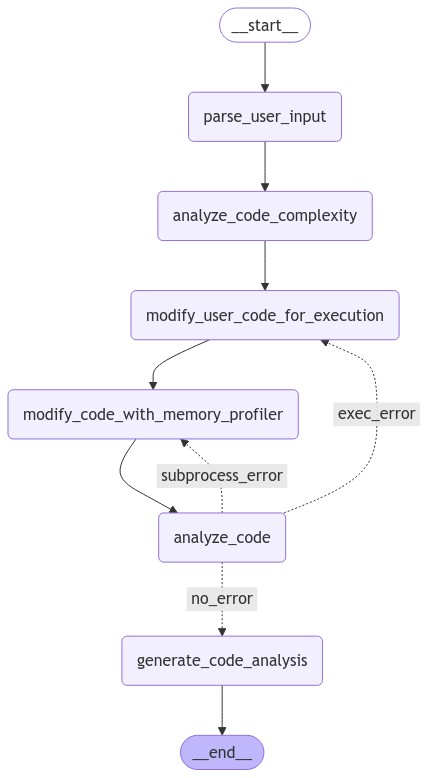

In [12]:
# 코드 분석 워크플로우 생성
code_analysis_workflow = StateGraph(CodeAnalysisState)

# 워크플로우에 각 기능을 노드로 추가
code_analysis_workflow.add_node("parse_user_input", parse_user_input)
code_analysis_workflow.add_node("analyze_code_complexity", analyze_code_complexity)
code_analysis_workflow.add_node("modify_user_code_for_execution", modify_user_code_for_execution)
code_analysis_workflow.add_node("modify_code_with_memory_profiler", modify_code_with_memory_profiler)
code_analysis_workflow.add_node("analyze_code", analyze_code)
code_analysis_workflow.add_node("generate_code_analysis", generate_code_analysis)

# 노드 간의 실행 순서를 설정
code_analysis_workflow.add_edge("parse_user_input", "analyze_code_complexity")
code_analysis_workflow.add_edge("analyze_code_complexity", "modify_user_code_for_execution")
code_analysis_workflow.add_edge("modify_user_code_for_execution", "modify_code_with_memory_profiler")
code_analysis_workflow.add_edge("modify_code_with_memory_profiler", "analyze_code")
code_analysis_workflow.add_edge("generate_code_analysis", END)

# 조건부 경로 설정 (에러 상태에 따라 경로가 달라짐)
code_analysis_workflow.add_conditional_edges(
    "analyze_code",
    lambda state: state["error_status"], # 상태에서 error_status 값을 추출
    {
        "no_error": "generate_code_analysis", # 오류가 없으면 generate_code_analysis로 이동
        "exec_error": "modify_user_code_for_execution", # 코드 실행 중 오류가 발생하면 modify_user_code_for_execution로 이동
        "subprocess_error": "modify_code_with_memory_profiler" # 서브프로세스 실행 중 오류가 발생하면 modify_code_with_memory_profiler로 이동
    }
)

# 워크플로우 시작점을 설정
code_analysis_workflow.set_entry_point("parse_user_input")

# 워크플로우를 컴파일하고 그래프 시각화
code_analysis_app = code_analysis_workflow.compile()
try:
    display(Image(code_analysis_app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [13]:
# code_analysis_agent 노드 생성 함수
def code_analysis_agent_node(state: AgentState):
    output = code_analysis_app.invoke(CodeAnalysisState(user_input=state["user_input"]))
    state["messages"].append(HumanMessage(content=output["output"], name="code_analysis_agent"))
    return state

# Algorithm Agent

In [14]:
from langchain_core.documents import Document  # Document 객체가 정의된 모듈에서 가져와야 함
from langchain.document_loaders import WikipediaLoader

# AlgorithmState 정의
class AlgorithmState(TypedDict):
    user_input: str
    output: str
    Wikipedia_search_query: str
    Wikipedia_Document: list[Document]
    Generated_answer: str

# Wikipedia 쿼리 출력을 위한 데이터
class WikipediaQueryOutput(BaseModel):
    Wikipedia_search_query: str = Field(description="The generated simple Wikipedia query based on the user's input.")

# Step 1: 사용자 입력을 기반으로 Wikipedia 검색 쿼리 생성
def generate_wikipedia_query(state: AlgorithmState):
    system_template = """
    You are an expert in algorithms and data structures.
    Based on the user's input, generate a simple query to search for the key concept on Wikipedia.
    Create the query to capture the essence of the user's question in simple keywords.
    """

    # 사용자 입력과 템플릿을 기반으로 검색 쿼리 생성
    chain = create_structured_output_chain(
        system_template=system_template,
        human_template="{user_input}",
        model="default",
        struct=WikipediaQueryOutput,
        partial_variables={"user_input": state["user_input"]}
    )
    return chain.invoke(state)


# Step 2: Wikipedia에서 쿼리로 문서 검색
def search_wikipedia(state: AlgorithmState) -> AlgorithmState:
    query = state["Wikipedia_search_query"] # 검색 쿼리 가져오기
    
    # WikipediaLoader로 문서 검색 (최대 2개)
    loader = WikipediaLoader(query=query, load_max_docs=2)
    documents = loader.load()
    
    state["Wikipedia_Document"] = documents

    return state

# LaTeX 이스케이프 처리 함수
def escape_latex(text):
    # LaTeX 수식을 찾아 이스케이프 처리 (줄바꿈 포함)
    def replace_latex(match):
        return '{{' + match.group(1) + '}}' + match.group(2)

    # LaTeX 수식 이스케이프 처리
    escaped = re.sub(r'(\{\\displaystyle [^}]+\})(\n?)', replace_latex, text)
    escaped = escaped.replace("{", "{{").replace("}", "}}") # 중괄호 이스케이프 처리
    
    return escaped

# Step 3: 검색된 결과를 바탕으로 답변 생성
def generate_answer(state: AlgorithmState) -> AlgorithmState:
    system_template = """
    Based on the Wikipedia content provided below, answer the user's question in a detailed and easy-to-understand way.
    
    Wikipedia content: {document_content}
    
    The user asked: {user_input}
    
    Provide a thorough and easy-to-follow explanation, ensuring the response is detailed and simplified for clear understanding using the Wikipedia data. 
    Additionally, use examples to make the explanation clearer and more relatable.
    """
    
    # 문서 내용 가져와 합치기 (이스케이프 처리 포함)
    documents = state["Wikipedia_Document"]
    document_content = " ".join([escape_latex(doc.page_content) for doc in documents])

    # 답변 생성 프롬프트
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", "{user_input}\n{document_content}")
    ])

    # 분석 수행
    chain = prompt | gpt3 | StrOutputParser()
    result = chain.invoke({"user_input": state["user_input"], "document_content": document_content})

    state["output"] = result
    return state

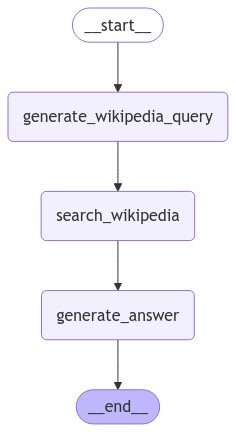

In [15]:
# 알고리즘 및 자료구조 교육 워크플로우 생성
Algorithm_workflow = StateGraph(AlgorithmState)

# 각 단계의 노드 추가
Algorithm_workflow.add_node("generate_wikipedia_query", generate_wikipedia_query)
Algorithm_workflow.add_node("search_wikipedia", search_wikipedia)
Algorithm_workflow.add_node("generate_answer", generate_answer)

# 노드 간의 연결 설정 (단계별 흐름)
Algorithm_workflow.add_edge("generate_wikipedia_query", "search_wikipedia")
Algorithm_workflow.add_edge("search_wikipedia", "generate_answer")
Algorithm_workflow.add_edge("generate_answer", END)

# 워크플로우의 시작점을 설정
Algorithm_workflow.set_entry_point("generate_wikipedia_query")

# 워크플로우 컴파일 및 그래프 시각화
Algorithm_app = Algorithm_workflow.compile()
try:
    display(
        Image(Algorithm_app.get_graph(xray=True).draw_mermaid_png())
    )  
except:
    pass

In [16]:
# Algorithm_agent 노드 생성 함수
def Algorithm_agent_node(state: AgentState):
    output = Algorithm_app.invoke(AlgorithmState(user_input=state["user_input"]))
    state["messages"].append(HumanMessage(content=output["output"], name="Algorithm_agent"))
    return state

# Main WorkFlow

In [17]:
# 메인 워크플로우 정의
main_workflow = StateGraph(AgentState)

# 각 에이전트 노드 추가
main_workflow.add_node("supervisor", supervisor_agent)
main_workflow.add_node("problem_content_agent", problem_content_agent_node)
main_workflow.add_node("coding_agent", coding_agent_node)
main_workflow.add_node("code_analysis_agent", code_analysis_agent_node)
main_workflow.add_node("Algorithm_agent", Algorithm_agent_node)

# 워크플로우 시작점을 supervisor로 설정
main_workflow.add_edge(START, "supervisor")

# 각 에이전트가 작업을 완료하면 항상 supervisor로 되돌아가도록 설정
for member in members:
    main_workflow.add_edge(member, "supervisor")

# 조건부 경로 설정: next 값에 따라 해당 에이전트로 이동 또는 작업 종료
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

# supervisor에서 next 값에 따라 다음 경로 설정
main_workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# 메인 워크플로우 컴파일
main_graph = main_workflow.compile()

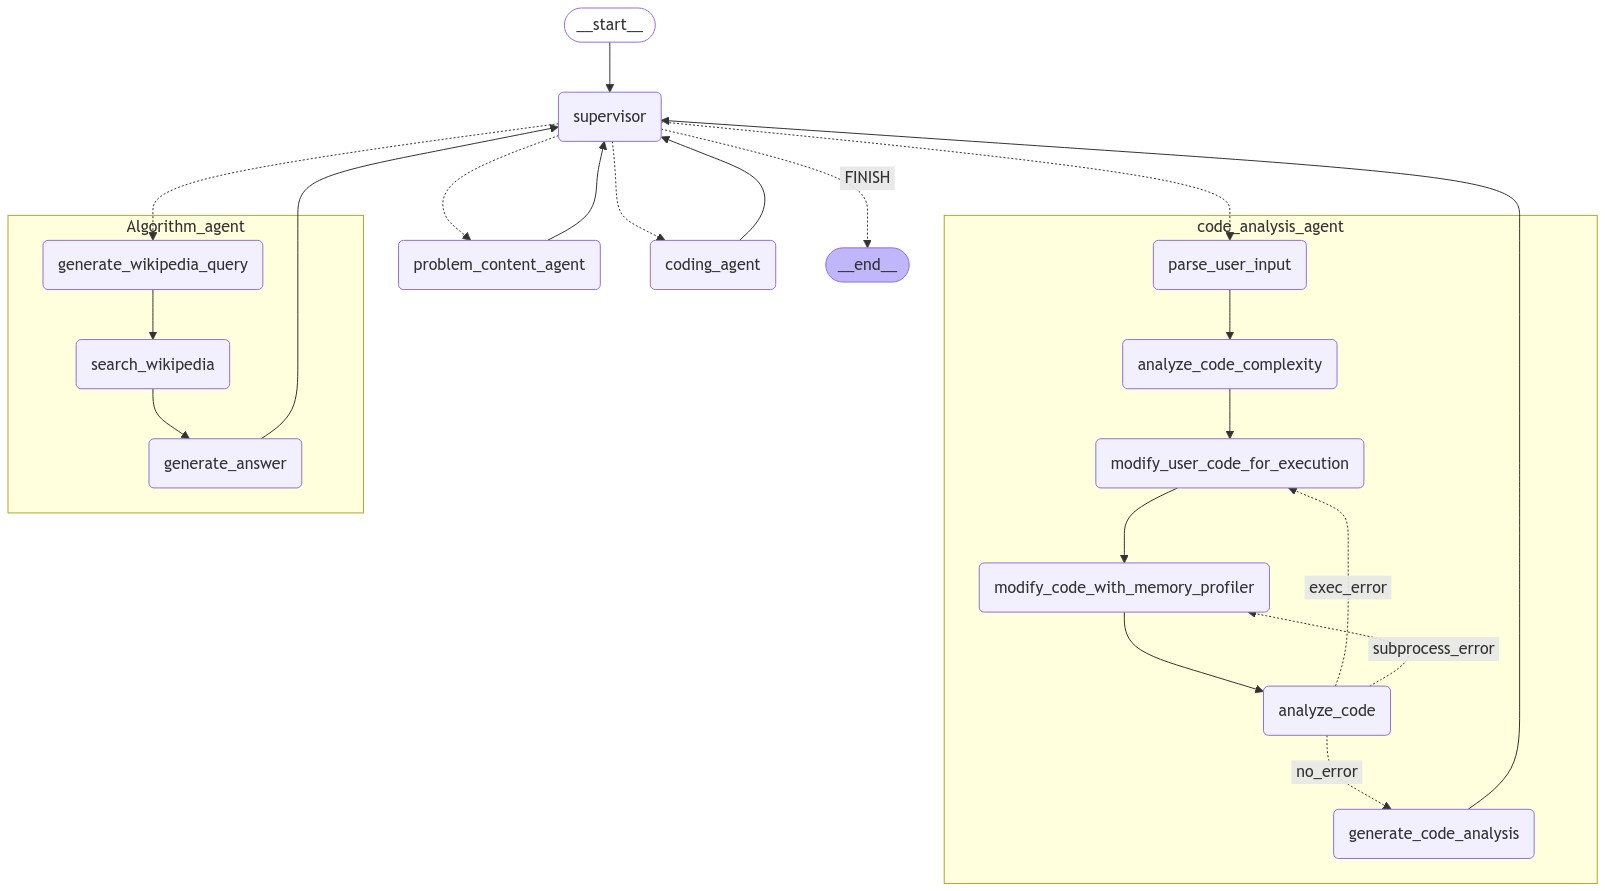

In [18]:
display(
        Image(main_graph.get_graph(xray=True).draw_mermaid_png())
)  

# 출력 TEST

In [27]:
# 문제 설명 test
test = "Please explain the content of Leetcode problem 12."

for s in main_graph.stream(
    {
        "user_input": test,
        "messages": [
            HumanMessage(
                content=test
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'problem_content_agent'}}
---


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df[df['problem_number'] == 12]"}`


    problem_number             title difficulty  \
11              12  Integer to Roman     Medium   

                                              content  
11  Roman numerals are represented by seven differ...  ### Leetcode Problem 12: Integer to Roman

#### Problem Description
Roman numerals are represented by seven different symbols: `I`, `V`, `X`, `L`, `C`, `D`, and `M`.

| Symbol | Value |
|--------|-------|
| I      | 1     |
| V      | 5     |
| X      | 10    |
| L      | 50    |
| C      | 100   |
| D      | 500   |
| M      | 1000  |

For example, the numeral `2` is written as `II` in Roman numeral, just two one's added together. The numeral `12` is written as `XII`, which is simply `X` + `II`. The number `27` is written as `XXVII`, which is `XX` + `V` + `II`.

Roman numerals are usually written large

In [18]:
# 프로그래밍 test
test = """
Write Python code to solve the following coding test problem.

Leetcode 1: TwoSum
Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.
You may assume that each input would have exactly one solution, and you may not use the same element twice.
You can return the answer in any order.

Example:
Input: nums = [2,7,11,15], target = 9
Output: [0,1]
Explanation: Because nums[0] + nums[1] == 9, we return [0, 1].

Please write the Python function starting with:
def two_sum(nums, target):
"""

for s in main_graph.stream(
    {
        "user_input": test,
        "messages": [
            HumanMessage(
                content=test
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'coding_agent'}}
---
 [2024-10-03 01:23:37][DEBUG]: == Working Agent: Python Coding Test Expert
 [2024-10-03 01:23:37][INFO]: == Starting Task: 
Your task is to solve coding test problems using Python.
You must:
- Carefully consider any constraints provided in the problem (e.g., time/space limits).
- If the user specifies a particular data structure or algorithm to be used, follow their instructions.
- Write efficient, clean Python code that solves the problem while adhering to these constraints.
- Ensure the solution handles all test cases, including edge cases.
- Make sure you fully understand the problem requirements and avoid any confusion about the problem's content or constraints. If anything is unclear, review the problem and clarify before proceeding with the solution.



> Entering new CrewAgentExecutor chain...
To effectively solve coding test problems using Python, I need to follow a structured approach. Let's start by defining a specific problem to s

In [28]:
# 코드 리뷰 test
test = """I need help with this coding problem: Leetcode Problem 200 - Number of Islands.
Given an m x n 2D binary grid grid which represents a map of '1's (land) and '0's (water), return the number of islands. An island is surrounded by water and is formed by connecting adjacent lands horizontally or vertically. You may assume all four edges of the grid are all surrounded by water.

Here's my code:
def numIslands(grid):
    if not grid:
        return 0
 
    rows, cols = len(grid), len(grid[0])
    num_islands = 0
 
    # DFS function to traverse the island
    def dfs(r, c):
        if r < 0 or c < 0 or r >= rows or c >= cols or grid[r][c] == '0':
            return
        grid[r][c] = '0'  # Mark the cell as visited
        # Visit all four directions
        dfs(r-1, c)
        dfs(r+1, c)
        dfs(r, c-1)
        dfs(r, c+1)
 
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == '1':
                dfs(r, c)
                num_islands += 1
 
    return num_islands

Can you review my code and test it with this input: 
grid = [
  ["1","1","0","0","0"],
  ["1","1","0","0","0"],
  ["0","0","1","0","0"],
  ["0","0","0","1","1"]
]
"""

for s in main_graph.stream(
    {
        "user_input": test,
        "messages": [
            HumanMessage(
                content=test
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'code_analysis_agent'}}
---
3
{'code_analysis_agent': {'user_input': 'I need help with this coding problem: Leetcode Problem 200 - Number of Islands.\nGiven an m x n 2D binary grid grid which represents a map of \'1\'s (land) and \'0\'s (water), return the number of islands. An island is surrounded by water and is formed by connecting adjacent lands horizontally or vertically. You may assume all four edges of the grid are all surrounded by water.\n\nHere\'s my code:\ndef numIslands(grid):\n    if not grid:\n        return 0\n \n    rows, cols = len(grid), len(grid[0])\n    num_islands = 0\n \n    # DFS function to traverse the island\n    def dfs(r, c):\n        if r < 0 or c < 0 or r >= rows or c >= cols or grid[r][c] == \'0\':\n            return\n        grid[r][c] = \'0\'  # Mark the cell as visited\n        # Visit all four directions\n        dfs(r-1, c)\n        dfs(r+1, c)\n        dfs(r, c-1)\n        dfs(r, c+1)\n \n    for r in range(rows):\n        f

In [30]:
# 알고리즘 및 자료구조 설명 test
test = "I don't really understand what the Selection Sort algorithm is. Please explain it to me in detail and in an easy way.

for s in main_graph.stream(
    {
        "user_input": test,
        "messages": [
            HumanMessage(
                content=test
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Algorithm_agent'}}
---
{'Algorithm_agent': {'user_input': "I don't really understand what the Selection Sort algorithm is. Please explain it to me in detail and in an easy way.", 'messages': [HumanMessage(content="I don't really understand what the Selection Sort algorithm is. Please explain it to me in detail and in an easy way."), HumanMessage(content="Selection Sort is a simple sorting algorithm used in computer science to arrange elements in a list in either ascending or descending order. Here's an easy-to-understand explanation of how Selection Sort works:\n\n1. **Basic Concept**:\n   - Selection Sort is an in-place comparison sorting algorithm, meaning it sorts the list by comparing elements and swapping them in the same array.\n   - It divides the input list into two parts: a sorted sublist on the left and an unsorted sublist on the right.\n   - Initially, the sorted sublist is empty, and the unsorted sublist contains all the elements.\n\n2. **Sorting Pr